In [31]:
import json
from collections.abc import Iterator
from os import PathLike
from pathlib import Path
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.figure import Figure
from optuna import Study
from optuna.study import get_all_study_names, load_study
from optuna.visualization import plot_parallel_coordinate, plot_param_importances
from prophet import Prophet
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import thesis.dataloading
import thesis.prophet_api

## Series Selection

In [2]:
def top_mid_bot(df: pd.DataFrame) -> pd.Series:
    s = df.mean().sort_values()
    return s.iloc[[-1, len(s)//2, 0]]  # type: ignore

In [3]:
electricity = thesis.dataloading.load_electricity("./datasets/electricity")
traffic = thesis.dataloading.load_traffic("./datasets/traffic")

In [4]:
electricity.mean().nlargest(5)

MT_043    1112.053181
MT_049     896.510056
MT_008     245.642546
MT_018     236.635178
MT_025     197.095669
dtype: float64

In [5]:

electricity.mean().nsmallest(5)

MT_003     1.719950
MT_001     4.641119
MT_007     6.718817
MT_019     7.978239
MT_023    10.443039
dtype: float64

In [15]:
top_mid_bot(electricity)

MT_043    1112.053181
MT_015      45.739936
MT_003       1.719950
dtype: float64

In [7]:
top_mid_bot(traffic)

400041    0.079530
400071    0.055126
400015    0.031022
dtype: float64

## Prophet images

In [17]:
"./output/original_output/electricity/prophet/"


for dataset_name in "electricity", "traffic":

    if dataset_name == "electricity":
        loader = thesis.dataloading.load_electricity
    elif dataset_name == "traffic":
        loader = thesis.dataloading.load_traffic
    else:
        raise ValueError(f"Invalid dataset name: {dataset_name}")

    df = loader(Path("datasets", dataset_name))

    for rank, series_name in zip(("top", "mid", "bot"), top_mid_bot(df).keys()):
        src = Path("output", "original_output", dataset_name, "prophet", series_name)
        tgt = Path(
            "..", "dsml-thesis-text", "figures", "results", dataset_name, "prophet"
        )

        copyfile(
            src / "components.png",
            tgt / "components" / f"{rank}.png",
        )
        copyfile(
            src / "forecasts.png",
            tgt / "predictions" / f"{rank}.png",
        )
        copyfile(
            src / "model.png",
            tgt / "models" / f"{rank}.png",
        )
        copyfile(
            src / "cv.png",
            tgt / "cvs" / f"{rank}.png",
        )

## Aggregate Metrics

In [6]:
def iter_events(
    path: str | PathLike[str],
) -> Iterator[tuple[str, str, EventAccumulator]]:
    path = Path(path)
    for x in path.glob("**/events.out.tfevents*"):
        model = x.parents[2].name
        dataset = x.parents[3].name
        event_acc = EventAccumulator(str(x))
        event_acc.Reload()
        yield dataset, model, event_acc


def extract_metrics(dataset_path: str | PathLike[str]) -> pd.DataFrame:
    metrics = ["test_MASE", "test_SMAPE", "test_RMSE", "test_MAE", "test_MAPE"]

    res = {}

    for _, model, event_acc in iter_events(dataset_path):

        scalars = event_acc.Tags()["scalars"]

        if metrics[0] in scalars:
            res[model] = [event_acc.Scalars(metric)[0].value for metric in metrics]

    df = pd.DataFrame.from_dict(
        res, orient="index", columns=[m.removeprefix("test_").lower() for m in metrics]
    )

    return df

In [7]:
print(
    extract_metrics("output/original_output/electricity/")
    .drop(columns="mape")
    .to_latex(
        # f"../dsml-thesis-text/tables/electricity_metrics.tex",
        float_format="%.5f",
        caption=f"Performance of the models on the Electricity Load Diagrams dataset.",
        label=f"tab:electricity_performance",
    )
)

\begin{table}
\caption{Performance of the models on the Electricity Load Diagrams dataset.}
\label{tab:electricity_performance}
\begin{tabular}{lrrrr}
\toprule
 & mase & smape & rmse & mae \\
\midrule
nbeats & 0.84079 & 0.10411 & 18.27056 & 7.59723 \\
deepvar & 0.65603 & 0.07951 & 15.06193 & 5.91165 \\
deepar & 0.63647 & 0.07828 & 14.04843 & 5.58480 \\
tft & 0.86392 & 0.10267 & 20.64952 & 7.88064 \\
\bottomrule
\end{tabular}
\end{table}



In [8]:
print(
    extract_metrics("output/original_output/traffic/").to_latex(
        # f"../dsml-thesis-text/tables/traffic_metrics.tex",
        float_format="%.5f",
        caption=f"Performance of the models on the PeMS-SF dataset.",
        label=f"tab:traffic_performance",
    )
)

\begin{table}
\caption{Performance of the models on the PeMS-SF dataset.}
\label{tab:traffic_performance}
\begin{tabular}{lrrrrr}
\toprule
 & mase & smape & rmse & mae & mape \\
\midrule
nbeats & 0.43610 & 0.10053 & 0.01195 & 0.00529 & 0.13326 \\
deepvar & 0.54191 & 0.16080 & 0.01073 & 0.00618 & 0.22869 \\
deepar & 0.43829 & 0.08678 & 0.01083 & 0.00494 & 0.10598 \\
tft & 0.40789 & 0.08864 & 0.01281 & 0.00495 & 0.10069 \\
\bottomrule
\end{tabular}
\end{table}



# Metrics Per Series

In [9]:
def extract_metric(dataset_path: str | PathLike[str], metric: str) -> pd.DataFrame:
    res = {}

    for model in ("nbeats", "deepar", "deepvar", "tft"):
        d = Path(dataset_path, model)
        p = next(d.glob("**/performance.csv"))
        s = pd.read_csv(p, index_col=0)["mase"]
        res[model] = s

    p = Path(dataset_path, "prophet", "results.csv")
    s = pd.read_csv(p, index_col=0)[metric]
    res["prophet"] = s

    df = pd.DataFrame(res)
    df = df.loc[:, ["prophet", "nbeats", "deepar", "deepvar", "tft"]]
    df = df.rename(
        columns={
            "nbeats": "N-BEATS",
            "deepar": "DeepAR",
            "deepvar": "DeepVAR",
            "tft": "TFT",
            "prophet": "Prophet",
        }
    )

    return df


def metric_heatmap(df: pd.DataFrame) -> Figure:
    fig = plt.figure(figsize=(12, 5))

    sns.heatmap(
        df.T,
        annot=False,
        cmap="magma_r",
        linewidths=0.5,
        cbar_kws={"label": "MASE"},
        xticklabels=True,
        robust=True,
    )
    plt.xlabel("Series")
    plt.ylabel("Model")
    plt.tight_layout()
    return fig

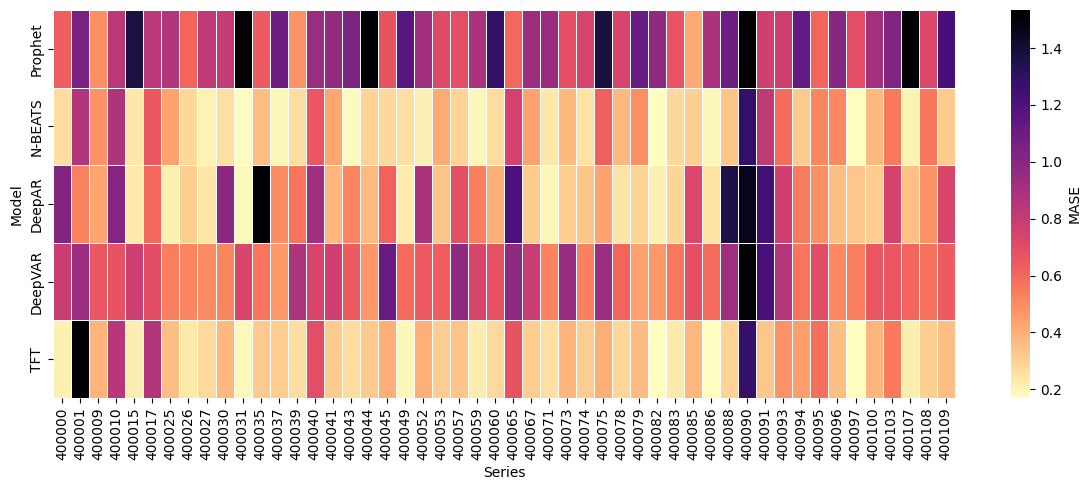

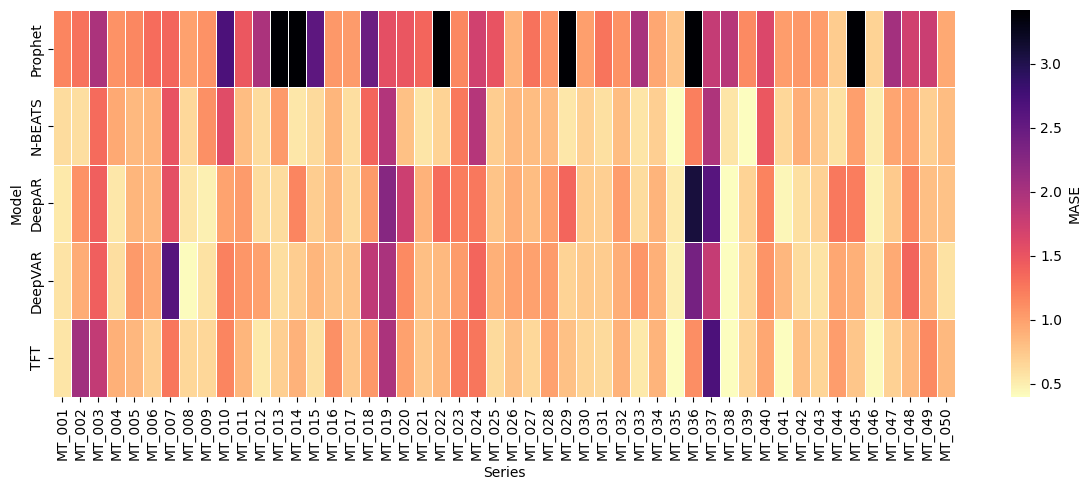

In [10]:
metric_heatmap(extract_metric("output/original_output/traffic/", "mase")).savefig(
    "../dsml-thesis-text/figures/results/traffic/mase_heatmap.png"
)
metric_heatmap(extract_metric("output/original_output/electricity/", "mase")).savefig(
    "../dsml-thesis-text/figures/results/electricity/mase_heatmap.png"
)

## Prophet Load

In [11]:
paths = [p for p in Path("output/original_output/").glob("*/prophet/*/") if p.is_dir()]
assert len(paths) == 100

path = paths[0]

params = json.loads((path / "params.json").read_text())
model = Prophet(**params)

# Optuna

In [33]:
deepvar_electricity_study = load_study(study_name="electricity-deepvar", storage="sqlite:///output/original_output/experiments-deepvar.db")
deepvar_traffic_study = load_study(study_name="traffic-deepvar", storage="sqlite:///output/original_output/experiments-deepvar.db")

In [26]:
def iter_studies(storage: str) -> Iterator[tuple[str, str, Study]]:
    for study_name in get_all_study_names(storage):
        study = load_study(study_name=study_name, storage=storage)
        dataset, model = study_name.split("-")
        yield dataset, model, study
        

In [34]:
# from optuna.study import copy_study

# for dataset_name in "electricity", "traffic":
#     copy_study(
#         from_study_name=f"{dataset_name}-deepvar",
#         to_study_name=f"{dataset_name}-deepvar",
#         from_storage="sqlite:///output/original_output/experiments-deepvar.db",
#         to_storage="sqlite:///output/original_output/experiments.db",
#     )

[I 2024-02-24 02:27:12,751] A new study created in RDB with name: electricity-deepvar
[I 2024-02-24 02:27:13,463] A new study created in RDB with name: traffic-deepvar


In [27]:
storage = "sqlite:///output/original_output/experiments.db"

In [28]:
for dataset, model, study in iter_studies(storage):
    plot_parallel_coordinate(study).write_image(
        f"../dsml-thesis-text/figures/results/{dataset}/{model}/parallel_coordinates.pdf"
    )
    plot_param_importances(study).write_image(
        f"../dsml-thesis-text/figures/results/{dataset}/{model}/param_importances.pdf"
    )

In [29]:
params = pd.DataFrame.from_dict(
    {
        (model, dataset): study.best_params
        for dataset, model, study in iter_studies(storage)
    },
    orient="index",
)

In [30]:
for model, df in params.groupby(level=0):
    df = df.dropna(axis=1, how="all").reset_index(level=0, drop=True)
    print(model)
    print(
        df.to_latex(
            caption=f"Best hyperparameter for {model}.",
            label=f"tab:{model}_best_params",
            position="H",
        )
    )
    print()

deepar
\begin{table}[H]
\caption{Best hyperparameter for deepar.}
\label{tab:deepar_best_params}
\begin{tabular}{lrrrr}
\toprule
 & hidden_size & gradient_clip_val & dropout & learning_rate \\
\midrule
electricity & 160.000000 & 5.828862 & 0.400000 & 0.005837 \\
traffic & 160.000000 & 44.437376 & 0.400000 & 0.004045 \\
\bottomrule
\end{tabular}
\end{table}


deepvar
\begin{table}[H]
\caption{Best hyperparameter for deepvar.}
\label{tab:deepvar_best_params}
\begin{tabular}{lrrrr}
\toprule
 & hidden_size & gradient_clip_val & dropout & learning_rate \\
\midrule
traffic & 160.000000 & 1.233625 & 0.300000 & 0.001032 \\
electricity & 80.000000 & 96.732676 & 0.500000 & 0.006023 \\
\bottomrule
\end{tabular}
\end{table}


nbeats
\begin{table}[H]
\caption{Best hyperparameter for nbeats.}
\label{tab:nbeats_best_params}
\begin{tabular}{lrrrrr}
\toprule
 & gradient_clip_val & dropout & learning_rate & trend & seasonality \\
\midrule
electricity & 1.602350 & 0.200000 & 0.000525 & 256.000000 & 2048.